# Figure 6: Generation 2 Convergence

## Manuscript Information
 
"Active Mutual Conjoint Estimation of Multiple Contrast Sensitivity
Functions"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_

[link to paper or preprint]

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

RMSE comparison between second-generation disjoint (blue) and conjoint (red) MLCSF estimates for
210 unique pairs of 20 representative CSF curves acting as ground truth.

## References

[references]


## Imports

In [1]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utility.utils import *
from QuickCSF import QuickCSF, simulate

### Check versions

In [2]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Run-time flags

In [3]:
qcsf_train_mode = False
train_mode = False          # create new data? Set to false if plotting existing results
verbose_mode = True         # print verbose analyses?
scrn_mode = True            # plot on screen?
save_results_mode = True    # save results to file?
save_plots_mode = True      # save plots to directory?

### Variables

In [4]:
# get data selection
jigo_file = '../data/raw/representative_curves.json'
representative_curves = load_json_from_file(jigo_file)
all_phenotypes = {
    'Quantile 1': representative_curves['quantile1-pid2-cue1-ecc3'],
    'Quantile 2': representative_curves['quantile2-pid1-cue1-ecc0'],
    'Quantile 3': representative_curves['quantile3-pid2-cue0-ecc2'],
    'Quantile 4': representative_curves['quantile4-pid3-cue0-ecc1'],
    'Quantile 5': representative_curves['quantile5-pid7-cue1-ecc3'],
    'Quantile 6': representative_curves['quantile6-pid0-cue0-ecc0'],
    'Quantile 7': representative_curves['quantile7-pid0-cue1-ecc0'],
    'Quantile 8': representative_curves['quantile8-pid1-cue1-ecc3'],
    'Quantile 9': representative_curves['quantile9-pid5-cue1-ecc0'],
    'Quantile 10': representative_curves['quantile10-pid8-cue0-ecc3'],
    'Quantile 11': representative_curves['quantile11-pid5-cue0-ecc1'],
    'Quantile 12': representative_curves['quantile12-pid8-cue1-ecc2'],
    'Quantile 13': representative_curves['quantile13-pid4-cue0-ecc1'],
    'Quantile 14': representative_curves['quantile14-pid7-cue0-ecc1'],
    'Quantile 15': representative_curves['quantile15-pid3-cue1-ecc2'],
    'Quantile 16': representative_curves['quantile16-pid0-cue0-ecc1'],
    'Quantile 17': representative_curves['quantile17-pid8-cue1-ecc0'],
    'Quantile 18': representative_curves['quantile18-pid8-cue0-ecc1'],
    'Quantile 19': representative_curves['quantile19-pid0-cue1-ecc1'],
    'Quantile 20': representative_curves['quantile20-pid4-cue0-ecc2']
}

def create_quantile_variables(num_quantiles):
    """
    Create a list of quantile names based on the number of quantiles.
    :param num_quantiles: Total number of quantiles.
    :return: List of quantile names.
    """
    return [f'Quantile {i+1}' for i in range(num_quantiles)]

# tasks and number of latents
num_latents = 2

# fixed unless something nutso happens 
num_tasks = num_latents

sampling_method = 'alternating'     # 'alternating' or 'unconstrained'
weight_decay = 1e-4
num_quantiles = 20

# Create "enums"
create_quantile_variables(num_quantiles)

# Configure for all unique pairs
num_pairs = comb(num_quantiles, 2) + num_quantiles

# choose to run multiple experiments with preset random seeds
# or a single experiment specifying your own random seeds
run_multiple_experiments = True

# list of zeros as long as num_latents
primer_random_seeds = [0, 0]
gp_random_seed = 0

# number of samples
num_halton_samples_per_task = 2
num_new_pts_per_task = 98

# choosing which figures to make
make_gp_gifs = True
make_entropy_gifs = False
make_hyper_plots = True

# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure06'

# Individual print flags 
print_training_hyperparameters = False
print_training_iters = False
print_progress_bar = False

# Set all to true if verbose_mode
if verbose_mode:
    print_training_hyperparameters = False
    print_training_iters = True
    print_progress_bar = False
    
# Create the bounds for the data
raw_freq_min = .5
raw_freq_max = 32
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04 # lapse rate is 4%
psi_sigma = 0.08
sigmoid_type = 'logistic'

# training parameters?
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_posterior = True
calculate_entropy = True

# GP hyperparameters?
learning_rate = .125
beta_for_regularization = .5
min_lengthscale = .15 # Note this changed from .2

# Set raw ghost points
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])

In [5]:
# import matplotlib.pyplot as plt

# # Get the number of arrays in the dictionary
# num_arrays = len(all_phenotypes)

# # Calculate the number of rows and columns for the subplots
# num_cols = 4
# num_rows = (num_arrays + num_cols - 1) // num_cols

# # Create a figure and subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

# # Flatten the axes array for easier indexing
# axes = axes.flatten()

# # Plot each array on a separate subplot
# for i, (quantile, data) in enumerate(all_phenotypes.items()):
#     ax = axes[i]
#     x, y = zip(*data)  # Unpack the x,y pairs from the list of tuples
#     ax.plot(x, y, color='orange')  # Plot x against y with the color 'orange'
#     ax.set_title(quantile)
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')

# # Remove any unused subplots
# for i in range(num_arrays, num_rows * num_cols):
#     fig.delaxes(axes[i])

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Display the plot
# plt.show()

### Set Timestamp to Save To

In [6]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
ensure_directory_exists(save_dir)
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure06/2024-04-15_19-12-33/


### Automatically calculated variables

In [7]:
# create common variables shared among all tasks
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(
        x_min, x_max, y_min, y_max, x_resolution, y_resolution)

grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)
def create_cubic_spline(curve):
    """
  This method creates a cubic spline to approximate the given curve.
  :param curve: A nx2 numpy matrix. First column is x values. Second column is y values.
  :return: The cubic spline.
  """
    x = curve[:, 0]
    y = curve[:, 1]

    cs = CubicSpline(x, y, extrapolate=False)
    return cs

# function to get ground truth curves
def get_spline(curve):
    """
    Modifies the curve by fitting a parabola through the maximum and the last points, then creates a cubic spline.
    The parabola's x-intercept is added to the curve if it is to the right of the last point.
    If the x-intercept is not to the right, the curve is not modified.
    :param curve: A list of [x, y] points.
    :return: The cubic spline.
    """
    curve = np.array(curve)
    curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(0.125)

    # Find the max y value and its corresponding x value
    max_y = np.max(curve[:, 1])
    max_y_index = np.argmax(curve[:, 1])
    x_max_y = curve[max_y_index, 0]

    # Use the last real point of the curve
    x_last, y_last = curve[-1, 0], curve[-1, 1]

    # Fit the parabola through the max and last point
    a = (y_last - max_y) / ((x_last - x_max_y)**2)
    coeffs = [a, -2*a*x_max_y, a*x_max_y**2 + max_y]
    roots = np.roots(coeffs)
    x_intercept = roots[0]  # Choose the first root

    # Add the intercept point to the curve only if it's to the right of the last point
    if x_intercept > x_last:
        curve = np.vstack([curve, [x_intercept, 0]])
        curve = curve[curve[:, 0].argsort()]  # Sorting by x values

    # Create and return the cubic spline
    cs = create_cubic_spline(curve)
    return cs

# get number of actively learned points for conjoint
num_pts_per_task = num_new_pts_per_task + num_halton_samples_per_task
num_new_conjoint_pts = num_new_pts_per_task * num_tasks
num_conjoint_pts = num_pts_per_task * num_tasks

# create ghost points and labels
ghost_x1 = logFreq().forward(raw_ghost_frequency)
ghost_x2 = logContrast().forward(raw_ghost_contrast)
assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

# create disjoint initial primer points
halton_X = get_halton_samples(xx, yy, num_halton_samples_per_task)
initial_disjoint_X = np.vstack((ghost_X, halton_X))

# create conjoint initial primer points and task indices
# simulated Halton y labels are created later for each experiment
halton_Xs = np.repeat(halton_X, num_tasks, axis=0)

num_ghost_points_per_task = len(ghost_y)
halton_task_indices = torch.arange(num_tasks).tile((num_halton_samples_per_task))

ghost_Xs = np.tile(ghost_X, (num_tasks, 1))
ghost_ys = np.tile(ghost_y, num_tasks)
ghost_task_indices = torch.arange(num_tasks).repeat_interleave(num_ghost_points_per_task)

num_disjoint_ghost_points = len(ghost_x2)
num_conjoint_ghost_points = len(ghost_task_indices)

# create initial dataset using ghost and halton samples
initial_Xs = np.vstack((ghost_Xs, halton_Xs))
initial_task_indices = torch.cat((ghost_task_indices, halton_task_indices))

# unique random seeds for halton samples and training
primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_pairs)]
gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_pairs)]

## Model Training

In [8]:
figure_dict = {
    "num_latents": num_latents,
    "sampling_method": sampling_method,
    "num_pairs": num_pairs,
    "num_halton_samples_per_task": num_halton_samples_per_task,
    "num_new_pts_per_task": num_new_pts_per_task,
    "raw_freq_min": raw_freq_min,
    "raw_freq_max": raw_freq_max,
    "raw_contrast_min": raw_contrast_min,
    "raw_contrast_max": raw_contrast_max,
    "x_resolution": x_resolution,
    "y_resolution": y_resolution,
    "raw_ghost_frequency": raw_ghost_frequency.tolist(),
    "raw_ghost_contrast": raw_ghost_contrast.tolist(),
    "primer_seeds_list": primer_seeds_list,
    "gp_seed_list": gp_seed_list,
    "weight_decay": weight_decay,
    "min_lengthscale": min_lengthscale,
    "psi_sigma": psi_sigma,
    "sigmoid_type": sigmoid_type,
    "psi_gamma": psi_gamma,
    "psi_lambda": psi_lambda,
    "lr": learning_rate,
    "num_initial_training_iters": num_initial_points_training_iters,
    "num_new_points_training_iters": num_new_points_training_iters,
    "beta_for_regularization": beta_for_regularization,
    "train_on_all_points_after_sampling": train_on_all_points_after_sampling,
    "print_training_hyperparameters": print_training_hyperparameters,
    "print_training_iters": print_training_iters,
    "progress_bar": print_progress_bar,
    "calculate_rmse": calculate_rmse,
    "calculate_entropy": calculate_entropy,
    "calculate_posterior": calculate_posterior
}

if train_mode:
    ensure_directory_exists(save_dir)
    with open(save_dir + "run_configs.json", 'w') as file:
        json.dump(figure_dict, file, indent=2)

### Disjoint

In [9]:
if train_mode:
    disjoint_results_dicts = [{} for _ in range(num_tasks)]
    disjoint_gp_lists = []

    all_phenotypes_keys = list(all_phenotypes.keys())  # Getting all the keys from your dictionary

    # Using itertools to get all unique combinations of length 2 (pairs)
    phenotype_pairs = combinations_with_replacement(all_phenotypes_keys, 2)

    # initialize pair index to iterate using actual numbers
    pair_index = 0

    # Now iterate over the first 'num_pairs' pairs
    for pair in phenotype_pairs:

        phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in pair]

        print(f"Pair {pair}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[pair_index]
        gp_seeds = gp_seed_list[pair_index]

        for i, (pheno, _) in enumerate(phenotype_pair):

            print(pheno)

            ground_truths = [get_spline(pheno_data) for _, pheno_data in phenotype_pair]

            cs = ground_truths[i]
            primer_seed = primer_seeds[i]
            gp_seed = gp_seeds[i]

            # get initial primer labels
            set_random_seed(primer_seed)
            halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma) # changed  psi_gamma, psi_lambda to 0, 0
            initial_y = np.hstack((ghost_y, halton_y))

            # run active learning
            set_random_seed(gp_seed)

            model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                cs,
                grid,
                xx,
                yy,
                sampling_strategy=sampling_strategy,
                mean_module_name=mean_module,
                psi_sigma=psi_sigma,
                sigmoid_type=sigmoid_type,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_pts_per_task,
                beta_for_regularization=beta_for_regularization,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                progress_bar=print_progress_bar,
                min_lengthscale=min_lengthscale,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                initial_Xs=initial_disjoint_X,
                initial_ys=initial_y,
                num_ghost_points=num_disjoint_ghost_points,
                weight_decay=weight_decay
            )


            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                    .reshape(xx.shape)

            disjoint_results_dicts[i][pair_index] = {
                'training_seed': gp_seed,
                'random_seed': primer_seed,
                'X': X,
                'y': y,
                'zz': zz,
                'rmse_list': rmse_list
            }

            gif_dict = {
                'xx': xx,
                'yy': yy,
                'X': X,
                'y': y,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': normalize_to_unit_range,
                'posterior_list': posterior_list,
            }

            # create gif of the task
            if make_gp_gifs and save_plots_mode:
                ntitle = pheno.replace(' ', '_')
                gif_path = f'{save_dir}/task{i}_{ntitle.lower()}/{pair_index}/'
                ensure_directory_exists(gif_path)
                create_and_save_plots(gif_dict, gif_path, ntitle, start_index=num_disjoint_ghost_points,
                            xticks_labels=x_tick_labels, yticks_labels=y_tick_labels)
                create_gif(gif_path)

            gp_list = [model for model, _ in posterior_list]
            disjoint_gp_lists.append(gp_list)
            print()

        # Increment the index for the next iteration
        pair_index += 1
        print(pair_index)

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}disjoint_results.pkl', 'wb') as file:
                pickle.dump(disjoint_results_dicts, file)


### Conjoint

In [10]:
if train_mode:
    conjoint_results_dicts = {}
    conjoint_gp_lists = []

    all_phenotypes_keys = list(all_phenotypes.keys())  # Getting all the keys from your dictionary

    # Using itertools to get all unique combinations of length 2 (pairs)
    phenotype_pairs = combinations_with_replacement(all_phenotypes_keys, 2)

    # initialize pair index to iterate using actual numbers
    pair_index = 0

    # Now iterate over the first 'num_pairs' pairs
    for pair in phenotype_pairs:

        phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in pair]

        print(f"Pair {pair}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[pair_index]

        # get unique halton labels for each experiment
        halton_y_list = []

        for i, _ in enumerate(phenotype_pair):
            ground_truths = [get_spline(pheno_data) for _, pheno_data in phenotype_pair]
            cs = ground_truths[i]
            set_random_seed(primer_seeds[i])
            halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
            halton_y_list.append(halton_y)

        # stack all task halton labels then stack ghost with halton labels
        halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
        initial_ys = np.hstack((ghost_ys, halton_ys))

        # run active learning
        set_random_seed(gp_seed)

        model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
            cs=ground_truths,
            grid=grid,
            xx=xx,
            yy=yy,
            psi_sigma=psi_sigma,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=learning_rate,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_conjoint_pts,
            beta_for_regularization=beta_for_regularization,
            phi=normalize_to_unit_range,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            train_on_all_points_iters=train_on_all_points_iters,
            min_lengthscale=min_lengthscale,
            initial_Xs=initial_Xs,
            initial_ys=initial_ys,
            sampling_strategy=sampling_strategy,
            num_ghost_points=num_conjoint_ghost_points,
            calculate_rmse=calculate_rmse,
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            progress_bar=print_progress_bar,
            num_tasks=num_tasks,
            num_latents=num_latents,
            task_indices=initial_task_indices,
            sampling_method=sampling_method,
            weight_decay=weight_decay
        )

        zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
            .reshape((*xx.shape, num_tasks))

        conjoint_results_dicts[pair_index] = {
            'training_seed': gp_seed,
            'random_seeds': primer_seeds,
            'X': X,
            'y': y,
            'zz': zz,
            'task_indices': task_indices,
            'entropy_list': entropy_list,
            'rmse_list': rmse_list
        }

        gp_list = [model for model, _ in posterior_list]
        conjoint_gp_lists.append(gp_list)
        print()

        # Increment the index for the next iteration
        pair_index += 1
        print(pair_index)

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}conjoint_results.pkl', 'wb') as file:
                pickle.dump(conjoint_results_dicts, file)


### qCSF

In [11]:
if qcsf_train_mode:
    
    qcsf_results = dict() # index like this: qcsf_results['Quantile 1']['rmses'], this will return a list of rmse values

    all_phenotypes_keys = list(all_phenotypes.keys())  # Getting all the keys from your dictionary

    
    for i in range (21): # each pheno appears 21 times in 210 pairs
        set_random_seed(i)
        for pheno in all_phenotypes_keys:

            k = pheno + ' - ' + str(i)
            pheno_data = np.array(all_phenotypes[pheno])

            print(k)

            simulationParams = {
                'trials': 100,
                'stimuli': {
                    'minContrast': raw_contrast_min,
                    'maxContrast': raw_contrast_max,
                    'contrastResolution': xs,
                    'minFrequency': raw_freq_min,
                    'maxFrequency': raw_freq_max,
                    'frequencyResolution': ys,
                },
                'parameters': None,
                'd': 1,  # guess rate used by qcsf model           
                'psiGamma': 0,
                'psiLambda': 0,
                'psiSigma': psi_sigma,
                "sigmoidType": sigmoid_type,
                'showPlots': False  # prevents plt from plotting every run 
            }

            rmses, times, params = simulate.runSimulation(
                trueThresholdCurve=pheno_data,
                **simulationParams
            )        

            qcsf_results[k] = dict()
            qcsf_results[k]['params'] = params
            qcsf_results[k]['rmses'] = rmses


            # save to disk
            ensure_directory_exists(save_dir)
            with open(save_dir + "qcsf_results.json", 'w') as file:
                json.dump(qcsf_results, file, indent=2)


## Load data

In [12]:

# load_dir = save_dir
load_dir = 'D:/Repos/delete_me/Figure06/'

with open(f'{load_dir}disjoint_results.pkl', 'rb') as file:
    disjoint_results_dicts = pickle.load(file)

with open(f'{load_dir}conjoint_results.pkl', 'rb') as file:
    conjoint_results_dicts = pickle.load(file)
    
    
    
    
# load qcsf

# qcsf_load_dir = save_dir + "qcsf_results.json"
qcsf_load_dir = 'analysis/Figure06/2024-04-15_04-23-55/qcsf_results.json'

with open(qcsf_load_dir, 'r') as file:
    qcsf_results = json.load(file)


In [13]:
keys_to_remove = [key for key in qcsf_results.keys() if key.startswith('Quantile 1') or key.startswith('Quantile 5') or key.startswith('Quantile 3')]

for key in keys_to_remove:
    del qcsf_results[key]

In [14]:
for key in qcsf_results.keys():
    print(key, qcsf_results[key]['rmses'][99])

Quantile 2 - 0 0.0951245227208615
Quantile 4 - 0 0.10569770765873233
Quantile 6 - 0 0.08868101442702576
Quantile 7 - 0 0.0627140585165837
Quantile 8 - 0 0.05094714382321306
Quantile 9 - 0 0.07728252659318602
Quantile 20 - 0 0.09919426769094558
Quantile 2 - 1 0.08843698571426445
Quantile 4 - 1 0.09656183481878368
Quantile 6 - 1 0.06799929245310471
Quantile 7 - 1 0.1150539667236192
Quantile 8 - 1 0.05407726503157639
Quantile 9 - 1 0.08416926555103026
Quantile 20 - 1 0.0788263738315708
Quantile 2 - 2 0.09808072616992554
Quantile 4 - 2 0.08847517006035853
Quantile 6 - 2 0.06790422230770986
Quantile 7 - 2 0.07964899634502844
Quantile 8 - 2 0.10288160748945646
Quantile 9 - 2 0.06510888519283345
Quantile 20 - 2 0.09505619014093525
Quantile 2 - 3 0.0882645892708488
Quantile 4 - 3 0.07450364262643568
Quantile 6 - 3 0.08084249544941381
Quantile 7 - 3 0.07820278174686278
Quantile 8 - 3 0.05605663901050449
Quantile 9 - 3 0.06402256076622788
Quantile 20 - 3 0.06312799412948555
Quantile 2 - 4 0.0855

## Create RMSE plot

### Formatting variables

In [15]:
figure_width = 6.5  # inches
figure_height = figure_width / 2  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'

title="RMSE Comparison"
rmse_x_label = "Sample Count"
rmse_y_label = "RMSE"

legend_font_size = 8
tick_font_size = 8
label_font_size = 10
title_font_size = 12

x_tick_labels = [.5, 2, 8, 32]
y_tick_labels = [1, 0.1, 0.01, 0.001]

DISJOINT, CONJOINT = "disjoint", "conjoint"
std_transparency = 0.2

rmse_x_ticks = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
rmse_y_ticks = np.arange(0, .31, step=0.05)
rmse_x_ticks_min, rmse_x_ticks_max = rmse_x_ticks[0], rmse_x_ticks[-1]
rmse_y_ticks_min, rmse_y_ticks_max = rmse_y_ticks[0], rmse_y_ticks[-1]

axis_tick_params = {'axis':'both', 'which':'major', 'direction':'out', 'length': 2}

filename = 'Figure06_Generation2Convergence'


### Plotting

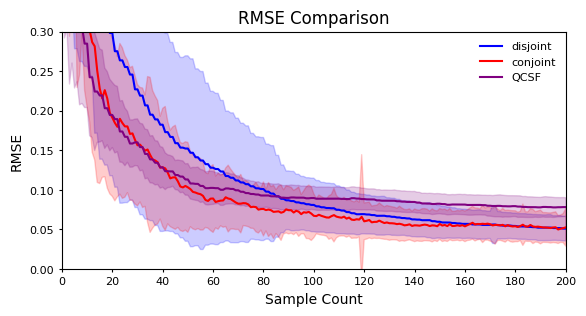

<Figure size 640x480 with 0 Axes>

In [16]:
num_pairs = len(conjoint_results_dicts.keys())

sample_count = np.arange(1, num_conjoint_pts + 1)

# Initialize arrays to store overall means and standard deviations
overall_mean = {DISJOINT: np.zeros(num_conjoint_pts), CONJOINT: np.zeros(num_conjoint_pts)}
overall_std = {DISJOINT: np.zeros(num_conjoint_pts), CONJOINT: np.zeros(num_conjoint_pts)}

# Calculating the overall mean and standard deviation for each condition
for condition, results_dicts, _ in [(DISJOINT, disjoint_results_dicts, 'blue'), (CONJOINT, conjoint_results_dicts, 'red')]:
    all_rmses = []
    for pair_idx in range(num_pairs):
        for task_idx in range(num_tasks):
            if condition == DISJOINT:
                rmse_list = np.repeat(results_dicts[task_idx][pair_idx]['rmse_list'], num_tasks)
            elif condition == CONJOINT:
                rmse_list = results_dicts[pair_idx]['rmse_list'][task_idx]
            all_rmses.append(rmse_list)
    overall_mean[condition] = np.mean(all_rmses, axis=0)
    overall_std[condition] = np.std(all_rmses, axis=0)
    
# Calculate the average RMSE values for each key in qcsf_results
qcsf_rmses = []
for key in qcsf_results.keys():
    rmses = qcsf_results[key]['rmses']
    qcsf_rmses.append(rmses)
qcsf_mean = np.mean(qcsf_rmses, axis=0)
qcsf_mean = np.repeat(qcsf_mean[:100], 2) # create the staircase
qcsf_std = np.std(qcsf_rmses, axis=0)    

# Set up the plot
fig, ax = plt.subplots(figsize=(figure_width, figure_height))

# Plotting
for condition, color in [(DISJOINT, 'blue'), (CONJOINT, 'red'), ("QCSF", 'purple')]:
    if condition == "QCSF":
        mean = qcsf_mean
        std = qcsf_std
    else:
        mean = overall_mean[condition]
        std = overall_std[condition]
    ax.plot(sample_count, mean, label=condition, color=color)
    ax.fill_between(sample_count, mean + std, mean - std, alpha=std_transparency, color=color)

# Setting plot attributes
ax.tick_params(**axis_tick_params, labelsize=tick_font_size)
ax.set_xlim(rmse_x_ticks_min, rmse_x_ticks_max)
ax.set_ylim(rmse_y_ticks_min, rmse_y_ticks_max)
ax.set_title(title, fontsize=title_font_size)
ax.set_xlabel(rmse_x_label)
ax.set_ylabel(rmse_y_label, fontsize=label_font_size)
ax.legend(loc='upper right', fontsize=legend_font_size, frameon=False)
ax.tick_params(axis='both', labelsize=tick_font_size)
plt.setp(ax, xticks=rmse_x_ticks, yticks=rmse_y_ticks)

plt.gcf().subplots_adjust(bottom=0.15)

# Saving or showing the plot
if save_plots_mode: 
    plt.savefig(f"{save_dir}{filename}.png", dpi=dpi_val)
    plt.savefig(f"{save_dir}{filename}.pdf", dpi=dpi_val)
if scrn_mode: 
    plt.show()
plt.clf()